# Cross-Canada Survey of Radon Concentrations in Homes

In [22]:
import numpy as np
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

print('Libraries imported')


Libraries imported


We downloaded the data online, however we had to download it as a csv file. In the file, there were additional columns that needed to be removed as the were empty. For the analysis we wish to coverm we are only interested in the Province/Territory variable.

In [23]:
url = "https://health.canada.ca/apps/open-data/radon-concentrations/radon-concentration.csv"

dfs = pd.read_csv(url)

dfs = dfs.drop(['ResultNumber','HealthRegionCode2007','Health Region2007','TestDurationInDays','ForwardSortationAreaCodes','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],axis = 1)

dfs.head()

,ProvinceTerritory,AverageRadonConcentrationInBqPerM3
0,NL,20
1,NL,36
2,NL,<15
3,NL,31
4,NL,26


To do the statistical tests on the dataset, we needed the Average Radon Concentration to be integer values. To achieve this we had to remove the values that were "<15", now this will cause some issues with the analysis but without speaking to the owner of the dataset, there is nothing we can do about this.

In [24]:
for badLabel in ['<15']:
    dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"] != badLabel]

dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"].notnull()]
dfs["AverageRadonConcentrationInBqPerM3"].unique()

dfs['AverageRadonConcentrationInBqPerM3'] = dfs['AverageRadonConcentrationInBqPerM3'].astype(int)

dfs = dfs[dfs["ProvinceTerritory"] != 'NU']

dfs.describe()

,AverageRadonConcentrationInBqPerM3
count,11218.0000
mean,116.9984
std,183.1173
min,15.0000
25%,30.0000
50%,72.0000
75%,133.0000
max,5657.0000


We wanted to see if there were any significant differences between the provinces. The first step would be to group by the province/territory and find some summary statistics.

In [25]:
dfsbyPT = dfs.groupby('ProvinceTerritory')
dfsbyPT.describe()

AverageRadonConcentrationInBqPerM3                      \
                                               count      mean       std   
ProvinceTerritory                                                          
AB                                            1077.0   96.0464   95.1525   
BC                                            1162.0  102.5422  167.3491   
MB                                            1102.0  160.3485  177.9877   
NB                                             728.0  203.2308  336.0620   
NL                                             479.0   86.9916  142.0475   
NS                                             428.0  125.7290  265.8510   
NT                                             146.0   85.9110  101.6563   
ON                                            3292.0   97.3840  160.7871   
PE                                              71.0   68.0704   76.3822   
QC                                            1348.0  104.0349  161.9337   
SK                                            1169.0  130.2258  137.2790   
YT                                             216.0  182.0278  313.6861   

                                                       
                    min    25%    50%     75%     max  
ProvinceTerritory                                      
AB                 15.0  37.00   75.0  121.00  1391.0  
BC                 15.0  25.00   55.0  110.00  2941.0  
MB                 15.0  55.00  110.5  203.00  1903.0  
NB                 15.0  37.00  104.0  227.00  5590.0  
NL                 15.0  22.00   35.0   97.00  1548.0  
NS                 15.0  25.00   42.5  114.25  2692.0  
NT                 15.0  29.00   58.0  109.75   924.0  
ON                 15.0  28.00   63.0  114.00  5657.0  
PE                 15.0  22.50   31.0   87.00   415.0  
QC                 15.0  26.00   55.0  121.00  2923.0  
SK                 15.0  60.00  100.0  159.00  2165.0  
YT                 15.0  43.75   92.5  165.75  2357.0

The next step will be to graph the values and see if they follow a normal distribution. Using a histogram, we can see that any assumption of normality is broken.

Text(0.5, 0.09, 'Concentration (Bq/m^3)')

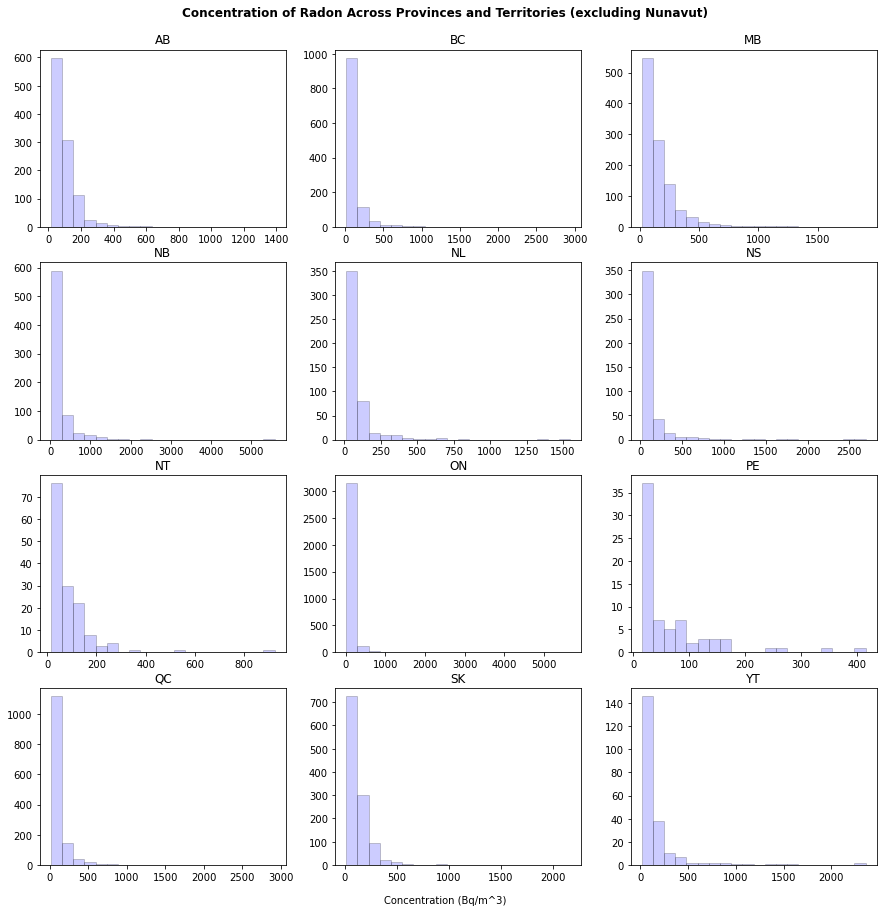

In [46]:
dfs_noNU = dfs[dfs["ProvinceTerritory"] != 'NU']
dfsbyPT_noNU = dfs_noNU.groupby("ProvinceTerritory")
fig, axs = plt.subplots(4,3)
fig.set_size_inches(15,15)
a = 0
for P in list(dfsbyPT_noNU.groups.keys()):
#    print(a%2)
    axs[int((a-a%3)/3),a%3].hist(dfsbyPT_noNU.get_group(P)['AverageRadonConcentrationInBqPerM3'],20,density=False,
    alpha=0.2,
    color='blue',
    edgecolor='k')
    axs[int((a-a%3)/3),a%3].set_title(P)
    a = a+1
fig.suptitle('Concentration of Radon Across Provinces and Territories (excluding Nunavut)',x=0.5,y=0.92, fontsize = 12, fontweight = "bold")
fig.text(0.5, 0.09, 'Concentration (Bq/m^3)', ha='center')

We can log transform the data but since there is a lower limit to the data, there is not much we can do about the normality of the data. We also see that when we consider the territory Nunavet, there are only 11 observations which will drastically change our analysis, so we will drop them from the dataset.

Text(0, 0.5, 'Log Concentration (Bq/m^3)')

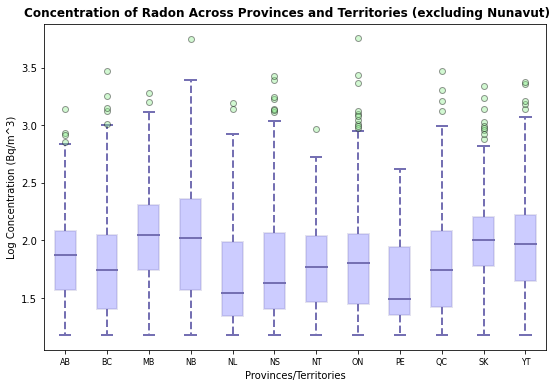

In [68]:
data_to_plot = []

for P in dfsbyPT.groups.keys():
    temp = np.log10(dfsbyPT.get_group(P)['AverageRadonConcentrationInBqPerM3'])
    data_to_plot.append(temp)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, patch_artist=True,whiskerprops = dict(linestyle='--'))
ax.set_xticklabels( dfsbyPT.groups.keys(), fontsize = 8)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="blue")

for box in bp['boxes']:
    # change outline color
    box.set(color='#7570b3', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue', alpha = 0.2 )
    
    box.set()
    
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2,linestyle='--')

for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

for median in bp['medians']:
    median.set(color='#7570b3', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', markerfacecolor="lightgreen", alpha=0.4)
    
fig.suptitle('Concentration of Radon Across Provinces and Territories (excluding Nunavut)',x=0.5,y=0.92, fontsize = 12, fontweight = "bold")
ax.set_xlabel('Provinces/Territories')
ax.set_ylabel('Log Concentration (Bq/m^3)')
#fig.text(0.5, 0.09, 'Log Concentration (Bq/m^3)', va='center')
#plt.xticks(np.arange(1,14), dfsbyPT.groups.keys())

Since we can not assume normality, we have to use a non-parametric anova test. To do so we will use the Kruskal Wallis test.

In [28]:
from scipy import stats

AB = data_to_plot[0]
BC = data_to_plot[1]
MB = data_to_plot[2]
NB = data_to_plot[3]
NL = data_to_plot[4]
NS = data_to_plot[5]
NT = data_to_plot[6]
ON = data_to_plot[7]
PE = data_to_plot[8]
QC = data_to_plot[9]
SK = data_to_plot[10]
YT = data_to_plot[11]

stats.kruskal(AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT)

KruskalResult(statistic=713.8841997074114, pvalue=5.693026989867524e-146)

Since there is a significant difference between the provinces, we can use a post hoc test to find the pairwise comparisons. To correct for FWER we will use a sidak correction.

In [31]:
import scikit_posthocs as sp

pd.set_option("precision", 3)

#data = pd.DataFrame({"AB": AB, "BC": BC, "MB": MB, "NB":NB,
                    #"NL":NL, "NS" : NS, "NT" : NT, "ON":ON,
                    #"PE" : PE, "QC" : QC, "SK" : SK, "YT" :YT })
#data = data.melt(var_name='groups', value_name='values')
#data
#data = [AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT]
sp.posthoc_dunn(dfs, p_adjust = 'sidak', group_col = "ProvinceTerritory", val_col = "AverageRadonConcentrationInBqPerM3")

,AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT
AB,1.000e+00,3.722e-08,0.000e+00,9.304e-08,3.664e-14,1.138e-04,5.957e-01,5.284e-06,1.389e-03,1.458e-05,1.230e-11,6.420e-02
BC,3.722e-08,1.000e+00,0.000e+00,0.000e+00,4.981e-02,1.000e+00,1.000e+00,8.700e-01,8.993e-01,1.000e+00,0.000e+00,4.915e-10
MB,0.000e+00,0.000e+00,1.000e+00,9.998e-01,0.000e+00,0.000e+00,2.563e-09,0.000e+00,3.119e-11,0.000e+00,1.000e+00,9.995e-01
NB,9.304e-08,0.000e+00,9.998e-01,1.000e+00,0.000e+00,0.000e+00,1.393e-06,0.000e+00,4.394e-09,0.000e+00,1.000e+00,1.000e+00
NL,3.664e-14,4.981e-02,0.000e+00,0.000e+00,1.000e+00,4.825e-01,6.604e-01,1.042e-05,1.000e+00,7.779e-04,0.000e+00,0.000e+00
NS,1.138e-04,1.000e+00,0.000e+00,0.000e+00,4.825e-01,1.000e+00,1.000e+00,9.989e-01,9.727e-01,1.000e+00,0.000e+00,3.437e-08
NT,5.957e-01,1.000e+00,2.563e-09,1.393e-06,6.604e-01,1.000e+00,1.000e+00,1.000e+00,9.103e-01,1.000e+00,1.156e-07,1.032e-03
ON,5.284e-06,8.700e-01,0.000e+00,0.000e+00,1.042e-05,9.989e-01,1.000e+00,1.000e+00,3.067e-01,1.000e+00,0.000e+00,4.408e-08
PE,1.389e-03,8.993e-01,3.119e-11,4.394e-09,1.000e+00,9.727e-01,9.103e-01,3.067e-01,1.000e+00,5.197e-01,6.602e-10,1.397e-06
QC,1.458e-05,1.000e+00,0.000e+00,0.000e+00,7.779e-04,1.000e+00,1.000e+00,1.000e+00,5.197e-01,1.000e+00,0.000e+00,2.984e-08
